In [416]:
from scipy.cluster import hierarchy  #用于进行层次聚类，话层次聚类图的工具包
from scipy import cluster   
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import MiniBatchKMeans, KMeans
# import xgboost as xgb
# import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import KernelPCA,PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import re
import warnings
warnings.filterwarnings("ignore")

In [417]:
test_path = '/python-file/恶意加密流量检测赛题/恶意加密流量检测决赛/test_1.csv'
test = pd.read_csv(test_path)
test_label = pd.read_csv('/python-file/恶意加密流量检测赛题/恶意加密流量检测决赛/样例/finalA/FastCloud_finalA969.csv')
test = test.merge(test_label,on = 'eventId',how='left')
print(test.shape)
eee = test[test['label'] == 1]
print(eee.shape)

(55974, 15)
(9306, 15)


In [418]:
test_path = '/python-file/恶意加密流量检测赛题/恶意加密流量检测决赛/test_1.csv'
test = pd.read_csv(test_path)
test_label = pd.read_csv('/python-file/恶意加密流量检测赛题/恶意加密流量检测决赛/样例/finalA/FastCloud_finalA.csv')
test = test.merge(test_label,on = 'eventId',how='left')
print(test.shape)
test = test[test['label'] == 1]
print(test.shape)

(55974, 15)
(9043, 15)


In [419]:
len(set(eee['eventId'])&set(test['eventId']))

8987

In [415]:
test['label'].mean()

1.0

In [391]:
test.isnull().sum()

srcAddress        0
srcPort           0
destAddress       0
destPort          0
appProtocol       0
tlsSubject      140
tlsIssuerDn     140
tlsSni         3362
tlsVersion        0
bytesOut          0
bytesIn           0
pktsIn            0
pktsOut           0
eventId           0
label             0
dtype: int64

In [392]:
test.columns

Index(['srcAddress', 'srcPort', 'destAddress', 'destPort', 'appProtocol',
       'tlsSubject', 'tlsIssuerDn', 'tlsSni', 'tlsVersion', 'bytesOut',
       'bytesIn', 'pktsIn', 'pktsOut', 'eventId', 'label'],
      dtype='object')

In [393]:
test.head()
for i in ['tlsSubject', 'tlsIssuerDn']:
    test[i+'_num'] = test[i].apply(lambda x:len(str(x).split(',')))

test['tlsVersion_num'] = test['tlsVersion'].apply(lambda x:re.findall(r"\d+\.?\d*",x)[0] if len(re.findall(r"\d+\.?\d*",x))==1 else np.nan).astype(float)
test['tlsVersion_num'] = test['tlsVersion_num'].fillna(test['tlsVersion_num'].min())


# for i in ['tlsSubject', 'tlsIssuerDn', 'tlsSni']:
#     test[i+'_num'] = test[i].fillna('').apply(lambda x:len(x))
# for i in ['srcAddress','destAddress']:
#     test[i+'_sum'] = test[i].apply(lambda x:np.sum([int(i) for i in x.split('.')]))
#     test[i+'_median'] = test[i].apply(lambda x:np.median([int(i) for i in x.split('.')]))
#     test[i+'_ptp'] = test[i].apply(lambda x:np.ptp([int(i) for i in x.split('.')]))
#     test[i+'_min'] = test[i].apply(lambda x:np.min(np.diff([int(i) for i in x.split('.')])))

In [394]:
test.select_dtypes('object').columns

Index(['srcAddress', 'destAddress', 'appProtocol', 'tlsSubject', 'tlsIssuerDn',
       'tlsSni', 'tlsVersion', 'eventId'],
      dtype='object')

In [395]:
de_col = ['srcAddress', 'destAddress', 'appProtocol', 'tlsSubject', 'tlsIssuerDn',
       'tlsSni', 'tlsVersion']
cols = [i for i in test.columns if i not in ['eventId','label']+de_col]
df = test[cols].copy()

In [396]:
scale = MinMaxScaler()
df = scale.fit_transform(df)

In [406]:
k_means = KMeans(n_clusters=5, random_state=2018).fit(df)
k_means_label = k_means.predict(df)

In [407]:
# from sklearn.metrics import silhouette_score

Text(0.5,1,'KMeans')

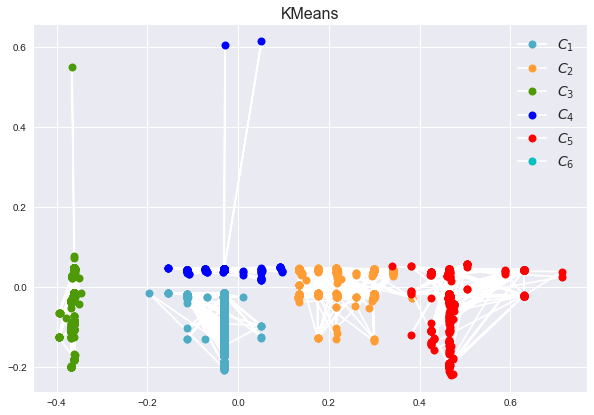

In [408]:
n=6
"""pca降维可视化"""
pca = PCA(n_components=2)
scale = MinMaxScaler()
data_pca = pca.fit_transform(df)
data_pca = pd.DataFrame(data_pca)
data_pca['label'] = k_means_label
# data['label'] = k_means_label
# data_all['label'] = k_means_label
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06','b','r','c','m']
ax = fig.add_subplot(1, 1, 1)
for k, col in zip(range(n), colors):
    my_members = k_means_label == k
#     print(my_members)
# my_members表示(k_means_label == k)的布尔判断结果
#     cluster_center = k_means_cluster_centers[k]
    ax.plot(data_pca.values[my_members, 0], data_pca.values[my_members, 1], 'w',
            markerfacecolor=col, marker='.',markersize=16, label='$'+'C_'+str(k+1)+'$')
plt.legend(fontsize=14)
ax.set_title('KMeans',fontsize=16)
# plt.savefig('../png/kmeans聚类结果.png',dpi=400, bbox_inches= 'tight')

In [420]:
pd.Series(k_means_label).value_counts()

3    3296
0    2634
2    1299
4    1071
1     681
dtype: int64

In [54]:
from sklearn import metrics

In [183]:
"""聚类评估"""
coef,coef2 = [], []
for i in range(2,30):
    kmeans_model = KMeans(n_clusters=i, random_state=1).fit(df)
    labels = kmeans_model.labels_
#     coef.append(metrics.silhouette_score(df, labels, metric='euclidean'))
    coef.append(metrics.davies_bouldin_score(df, labels))

    agg_model = AgglomerativeClustering(n_clusters=i, linkage='ward').fit(df)
    labels = agg_model.labels_
#     coef2.append(metrics.silhouette_score(df, labels, metric='euclidean'))
    coef2.append(metrics.davies_bouldin_score(df, labels))

Text(0.5,1,'SC Curve')

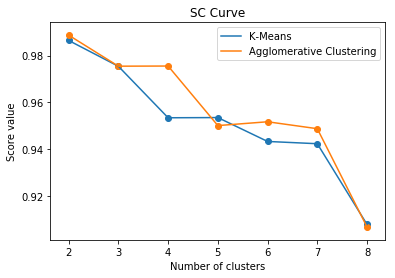

In [56]:
# plt.plot(range(2,9), coef, label='K-Means')
# plt.scatter(range(2,9), coef)
# plt.plot(range(2,9), coef2, label='Agglomerative Clustering')
# plt.scatter(range(2,9), coef2)
# plt.legend()
# plt.xlabel('Number of clusters')
# plt.ylabel('Score value')
# plt.title('SC Curve')
# plt.savefig('../png/kmeans3_6_7_SC.png',dpi=400, bbox_inches= 'tight')

Text(0.5,1,'SC Curve')

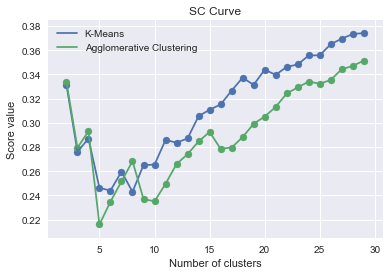

In [181]:
plt.plot(range(2,30), coef, label='K-Means')
plt.scatter(range(2,30), coef)
plt.plot(range(2,30), coef2, label='Agglomerative Clustering')
plt.scatter(range(2,30), coef2)
plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('Score value')
plt.title('SC Curve')

Text(0.5,1,'SC Curve')

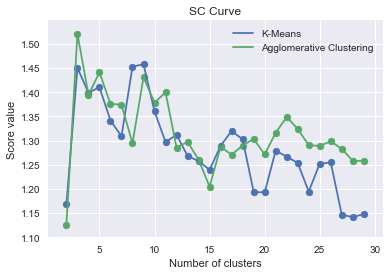

In [184]:
plt.plot(range(2,30), coef, label='K-Means')
plt.scatter(range(2,30), coef)
plt.plot(range(2,30), coef2, label='Agglomerative Clustering')
plt.scatter(range(2,30), coef2)
plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('Score value')
plt.title('SC Curve')

## 标准化

Text(0.5,1,'SC Curve')

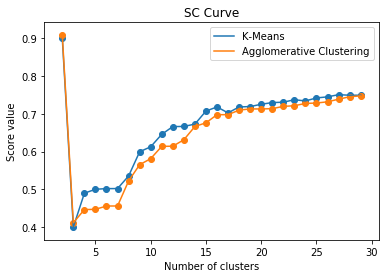

In [92]:
plt.plot(range(2,30), coef, label='K-Means')
plt.scatter(range(2,30), coef)
plt.plot(range(2,30), coef2, label='Agglomerative Clustering')
plt.scatter(range(2,30), coef2)
plt.legend()
plt.xlabel('Number of clusters')
plt.ylabel('Score value')
plt.title('SC Curve')

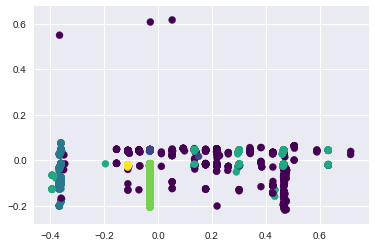

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# #产生实验数据
# df
# X = X[:, ::-1] #方便画图

from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=6).fit(df) #指定聚类中心个数为4
labels = gmm.predict(df)
pca = PCA(n_components=2)
X = pca.fit_transform(df)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')


array([0, 1, 2, 3, 4, 5], dtype=int64)